In [23]:
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import wordnet as wn
from pprint import pprint
import torch.nn.functional as F
import os
import glob
import tqdm 
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import pytorch_lightning as pl
import wandb
import re
from model import AutoEncoder, HookedModel, DictionnaryLearner, default_hookedmodel, default_ae
import networkx as nx
from wordnet_data.imagenet_classes_helpers import common_superclass_wnid, ImageNetHierarchy
#%load_ext tensorboard

In [2]:
def load_model(generic_path, wandb_id, epoch = -1):
    path = os.path.join(generic_path, wandb_id, 'checkpoints')
    if epoch == -1:
        ## Create a list of all the epochs with a regex
        epochs = [int(re.findall(r'epoch=(\d+)', x)[0]) for x in os.listdir(path)]
        ## Get the last epoch
        epoch = max(epochs)
    ## Get the ckpt file starting with epoch={epoch}
    ckpt = [x for x in os.listdir(path) if x.startswith(f'epoch={epoch}')][0]
    model = DictionnaryLearner.load_from_checkpoint(os.path.join(path, ckpt))
    return model

In [6]:
!bash dataload_val_only.sh

/tmp/imagenet ~/VisionMonoSemanticity
~/VisionMonoSemanticity


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [145]:
model = load_model('/mnt/home/dheurtel/ceph/02_checkpoints/monosemantic_dictionnary_learning/', 'xz7mfk10', -1).to(device)

In [146]:
valdir = os.path.join('/tmp/imagenet/', 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
def unormalize(batch):
    ## batch of shape (batch_size, 3, 224, 224)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    return batch * std + mean

val_dataset = datasets.ImageFolder(
    valdir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))    

In [147]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=8)

In [148]:
len(val_dataset), len(val_loader)

(50000, 98)

In [203]:
feature_acts = torch.zeros(len(val_dataset), model.autoencoder.d_hidden)
all_classes = torch.zeros(len(val_dataset))

progress_bar = tqdm.tqdm(total=len(val_loader), desc='Val', position=0)
for i, (batch, classes) in enumerate(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        loss, x_reconstruct, acts, l2_loss, l1_loss = model(batch)
    idx_min = i * 512
    idx_max = min((i+1) * 512, len(val_dataset))
    feature_acts[idx_min: idx_max, :] = acts.cpu().detach()
    all_classes[idx_min: idx_max] = classes
    progress_bar.update(1)

Val:   0%|          | 0/98 [00:55<?, ?it/s]


RuntimeError: The expanded size of the tensor (2540) must match the existing size (508) at non-singleton dimension 1.  Target sizes: [512, 2540].  Tensor sizes: [512, 508]

In [204]:
neuron_acts = torch.zeros(len(val_dataset), model.autoencoder.d_input)
all_classes = torch.zeros(len(val_dataset))

progress_bar = tqdm.tqdm(total=len(val_loader), desc='Val', position=0)
for i, (batch, classes) in enumerate(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        acts = model.hookedmodel(batch)
    idx_min = i * 512
    idx_max = min((i+1) * 512, len(val_dataset))
    neuron_acts[idx_min: idx_max, :] = acts.cpu().detach()
    all_classes[idx_min: idx_max] = classes
    progress_bar.update(1)

Val: 100%|██████████| 98/98 [00:36<00:00,  3.87it/s]

In [205]:
dead_neurons = (neuron_acts.sum(dim=0) == 0).nonzero().flatten()

In [206]:
len(dead_neurons)/neuron_acts.shape[1]

0.0

In [207]:
non_dead_neurons = (neuron_acts.sum(dim=0) != 0).nonzero().flatten()
len(non_dead_neurons)

508

In [208]:
neuron_acts.sum()/neuron_acts.shape[0]/neuron_acts.shape[1]

tensor(18.8114)

In [209]:
## Sort the classes by neuron_0_acts
neuron_to_inspect = 2000
neuron_to_inspect = non_dead_neurons[1]
sorted_classes_idx = torch.argsort(neuron_acts[:, neuron_to_inspect])
sorted_classes = all_classes[sorted_classes_idx]

In [210]:
sorted_classes[-100:]

tensor([830., 508., 984., 222., 108., 794., 440.,  56., 969., 694., 600., 830.,
        499., 607., 740., 841., 581., 877., 999., 762., 776., 711., 590., 890.,
        453., 743.,  15., 479., 890., 662., 842., 784., 421., 789., 499., 561.,
        508., 476., 646., 822., 420., 559., 579., 644., 723., 694., 917., 694.,
        743., 907., 694., 541., 895., 716., 917., 721., 810., 506., 429., 694.,
        749., 558., 445., 723., 641., 787., 800., 947., 150., 839., 734., 415.,
        698., 701., 499., 921., 508., 828., 531., 694., 520., 533., 716., 538.,
        877., 519., 917., 954., 767., 694., 721., 611., 734.,   1., 846., 653.,
        694., 806., 912., 877.])

In [211]:
summed_acts = (neuron_acts[:,non_dead_neurons]>0).sum(dim=1, dtype=torch.float32)

In [212]:
summed_acts[1]

tensor(508.)

In [213]:
summed_acts.mean(), summed_acts.std(), len(non_dead_neurons)

(tensor(501.6107), tensor(7.3760), 508)

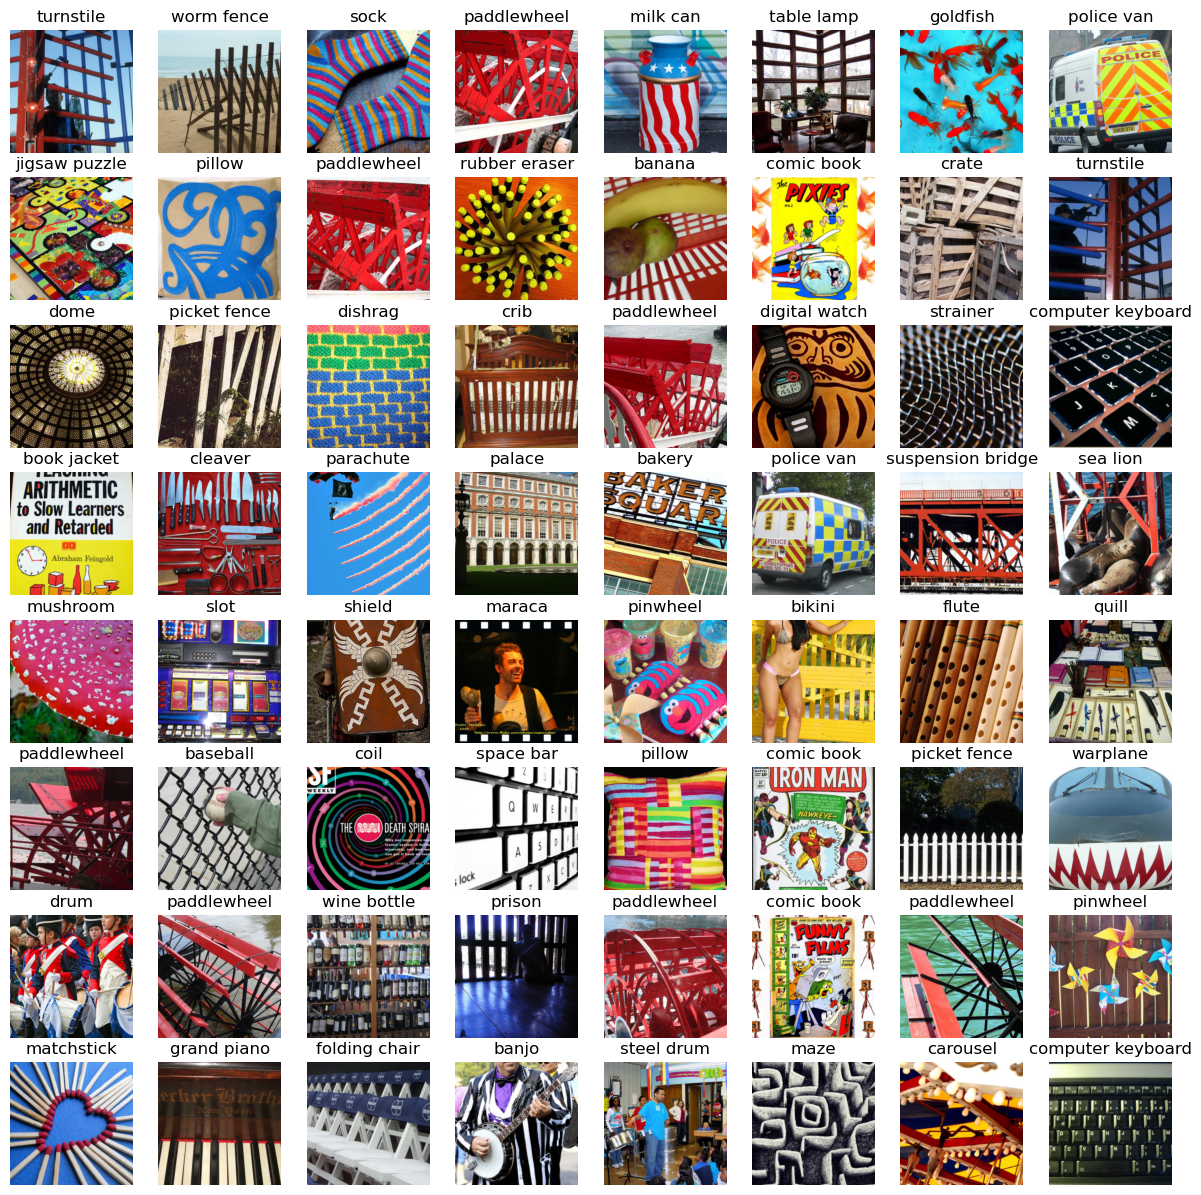

In [215]:
## Plot the 25 images that activate the most the first neuron (use dataset[idx])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8, figsize=(15,15))

for i in range(8):
    for j in range(8):
        idx = sorted_classes_idx[-(i*8+j+1)]
        img, label = val_dataset[idx]
        img = img.unsqueeze_(0)
        ## Clamp the values between 0 and 1 then 255 int
        img = unormalize(img)[0]
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].set_title(idx2classes[label].split(',')[0])
        axs[i, j].axis('off')

plt.show()

In [13]:
## Get the dictionary of classes for ImageNet

CLASSES_FILE = './classes/imagenet1000_clsidx_to_labels.txt'

with open(CLASSES_FILE) as f:
    idx2classes = eval(f.read())

classes2idx = {v: k for k, v in idx2classes.items()}
simple_classes2idx = {k.split(',')[0]: v for k, v in classes2idx.items()}

In [15]:
os.makedirs('/tmp/imagenet/train', exist_ok=True) ## EMPTY FOLDER
## Make a subfolder for each class, copying the subfolders names in val (for the Imagene hierarchy)
l = os.listdir(valdir)

for c in l:
    os.makedirs(os.path.join('/tmp/imagenet/train', c), exist_ok=True)

In [16]:
in_hier = ImageNetHierarchy('/tmp/imagenet/', './wordnet_data/')

72581
